<a href="https://colab.research.google.com/github/gilad-altshuler/Three_Body_RNN/blob/main/notebooks/5_Neural_Trajectory_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Three_Body_RNN
    %cd Three_Body_RNN
    ROOT = Path(".").resolve()

    # Load Arial font
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"

else:
    print("Not running in Colab.")
    ROOT = Path(__file__).resolve().parent.parent
    sys.path.append(str(ROOT))
    sys.path.insert(0, str(ROOT.parent / "lowrank_inference"))

Running in Colab. Cloning repo...
Cloning into 'Three_Body_RNN'...
remote: Enumerating objects: 1147, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1147 (delta 120), reused 142 (delta 63), pack-reused 936 (from 2)
Receiving objects: 100% (1147/1147), 476.21 MiB | 40.32 MiB/s, done.
Resolving deltas: 100% (613/613), done.
/content/Three_Body_RNN
--2025-08-23 21:26:36--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2025-08-23 21:26:36--  https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133,

In [2]:
import torch
import random
from torch import nn
import numpy as np
import copy
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
if IN_COLAB:
  fm.fontManager.addfont('Arial.ttf')
  arial_fp = fm.FontProperties(fname='Arial.ttf')
  plt.rcParams['font.family'] = arial_fp.get_name()
else:
  plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 10
import seaborn as sns


import utils
from tasks.MultiFate_task import generate_data
from Models import *

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Mante-inference

In [3]:
DATA_DIR = ROOT / "data" / "mante_inference"
FIG_DIR = ROOT / "notebooks" / "figures"

In [6]:
import pickle
with open(DATA_DIR / "r2s.pkl", "rb") as f:
    r2s = pickle.load(f)

In [7]:
samples = len(r2s['test']['hornn'])
ranks = 5

modes = ['train','valid','test']
models = ["RNN", "HORNN"]
for m in modes:
  r2s[m]['hornn'] = r2s[m]['hornn'].reshape(1,samples).repeat(ranks,axis=0)

In [8]:
# def bootstrap_ci(data,n_boot,ci=95):

#   lbs = []
#   ubs = []

#   for rank in data:
#       boot_means = []
#       for _ in range(n_boot):
#           sample = np.random.choice(rank, size=len(rank), replace=True)
#           boot_means.append(np.mean(sample))
#       boot_means = np.array(boot_means)

#       lbs.append(np.percentile(boot_means, (100-ci)/2))
#       ubs.append(np.percentile(boot_means, (100+ci)/2))

#   lbs = np.array(lbs)
#   ubs = np.array(ubs)
#   return lbs,ubs

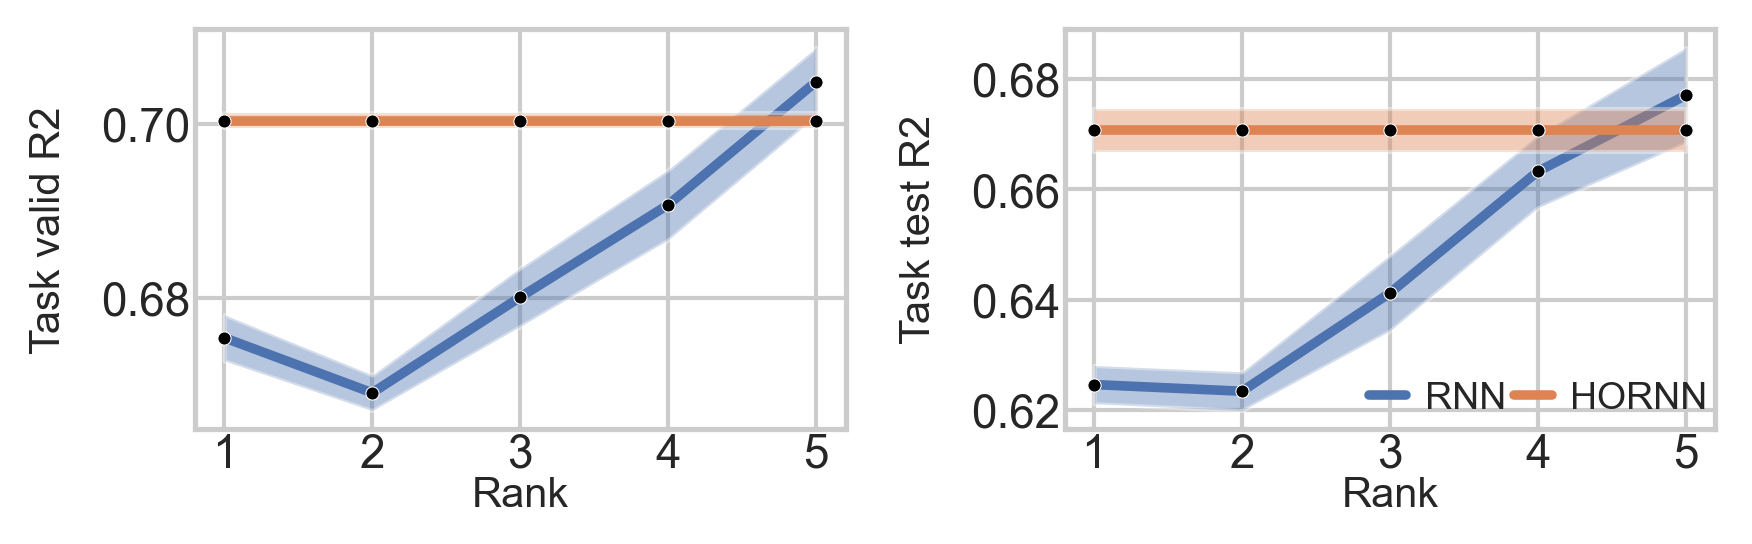

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
r = np.arange(1, ranks + 1)

# Plot using seaborn
fig = plt.figure(figsize=(6, 2), dpi=300)
axes = fig.subplots(1,2)
sns.set(style="whitegrid", font_scale=1)

for ax, m in zip(axes,modes[1:]):

  records = []

  for model in models:
    mean = np.mean(r2s[m][model.lower()], axis=-1)
    ste = np.std(r2s[m][model.lower()], axis=-1) / (samples**0.5)
    # d_err,u_err = bootstrap_ci(r2s[m][model.lower()],10000,ci=99)
    d_err,u_err = mean-ste,mean+ste
    for i in range(ranks):
        records.append({
            "Rank": r[i],
            "R2": mean[i],
            "u_err": u_err[i],
            "d_err": d_err[i],
            "Model": model
        })

  df = pd.DataFrame(records)

  # Plot each model with ribbon
  for model in df["Model"].unique():
      sub = df[df["Model"] == model]
      sns.lineplot(ax=ax,data=sub, x="Rank", y="R2", label=model if ax==axes[-1] else None, linewidth=2.3,zorder=1)
      sns.scatterplot(ax=ax,data=sub, x="Rank", y="R2", label=None, s=10, color="black",zorder=2)
      ax.fill_between(
          sub["Rank"], sub["d_err"], sub["u_err"], alpha=0.4,
          label=None
      )

  # Labels and formatting
  ax.set_xlabel("Rank", fontsize=10,labelpad=0)
  ax.set_ylabel(f"Task {m} R2", fontsize=10,labelpad=8)
  ax.set_xticks(list(range(1,ranks+1)))
  ax.tick_params(axis='both', which='major', pad=-5)

legend = ax.legend(frameon=False,fontsize=9,loc='lower right',bbox_to_anchor=(1.04, -0.05),ncol=2,columnspacing=0.2,handletextpad=0.5,handlelength=1.0)
# fig.subplots_adjust(left=0.05,right=0.95,bottom=0.1,top=0.9)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/mante.png", dpi=300, bbox_inches='tight')
plt.show()


# Reach-inference

In [5]:
DATA_DIR = ROOT / "data" / "reach_inference"
FIG_DIR = ROOT / "notebooks" / "figures"

In [6]:
import pickle
with open(DATA_DIR / "r2s.pkl", "rb") as f:
    r2s = pickle.load(f)

In [11]:
for key,val in r2s.items():
  ste = val.std()/(30**0.5)
  mean = val.mean()
  print(key,f"mean: {mean} ",mean+ste,mean-ste)

r_5_rnn mean: 0.8768992526777859  0.8834022308985828 0.870396274456989
r_6_rnn mean: 0.9112211589155526  0.9120165949113889 0.9104257229197162
r_4_r_1_hornn mean: 0.8798397635591442  0.8850990316309268 0.8745804954873615
r_5_r_1_hornn mean: 0.909487822960163  0.9102369143206848 0.9087387315996411
r_6_r_1_hornn mean: 0.9130055883835102  0.913550585920964 0.9124605908460564
